## Load Data

In [1]:
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

## Sampling

In [3]:
import numpy as np

import keras
from keras import layers
from keras import backend as K
from keras.models import Model

In [4]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Encoder

In [5]:
latent_dim = 2

In [7]:
input_img= keras.Input(shape=(28,28,1))

layer1 = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
layer2 = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(layer1)
layer3 = layers.Conv2D(64, 3, padding='same', activation='relu')(layer2)
layer4 = layers.Conv2D(64, 3, padding='same', activation='relu')(layer3)
shape_before_flattening = K.int_shape(layer4)

x = layers.Flatten()(layer4)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encode = Model(input_img, z)
encode.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
____________________________________________________________________________________________

## Decode

In [10]:
decode_input = layers.Input(K.int_shape(z)[1:])

upsample = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decode_input)

decode_1 = layers.Reshape(shape_before_flattening[1:])(upsample)
decode_2 = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(decode_1)
decode_3 = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(decode_2)

decoder = Model(decode_input, decode_3)

z_decoded = decoder(z)

## Loss

In [11]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        k1_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + k1_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [12]:
y = CustomVariationalLayer()([input_img, z_decoded])

## Construct final model and train

In [15]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_6[0][0]                   
____________________________________________________________________________________________

/home/cyp/anaconda3/envs/tensorflow_36/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [17]:
vae.fit(x=x_train, y=None,shuffle=True, epochs=10, batch_size=16, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 35s 586us/step - loss: 0.2106 - val_loss: 0.1966
Epoch 2/10
60000/60000 [==============================] - 34s 563us/step - loss: 0.1937 - val_loss: 0.1902
Epoch 3/10
60000/60000 [==============================] - 34s 561us/step - loss: 0.1894 - val_loss: 0.1873
Epoch 4/10
60000/60000 [==============================] - 33s 551us/step - loss: 0.1870 - val_loss: 0.1858
Epoch 5/10
60000/60000 [==============================] - 34s 564us/step - loss: 0.1853 - val_loss: 0.1862
Epoch 6/10
60000/60000 [==============================] - 34s 566us/step - loss: 0.1841 - val_loss: 0.1835
Epoch 7/10
60000/60000 [==============================] - 34s 566us/step - loss: 0.1834 - val_loss: 0.1826
Epoch 8/10
60000/60000 [==============================] - 34s 565us/step - loss: 0.1826 - val_loss: 0.1815
Epoch 9/10
60000/60000 [==============================] - 34s 559us/step - loss: 0.1819 - val_

## Showcase

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [19]:
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [23]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, 16).reshape(16, 2)
        x_decoded = decoder.predict(z_sample, batch_size=16)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

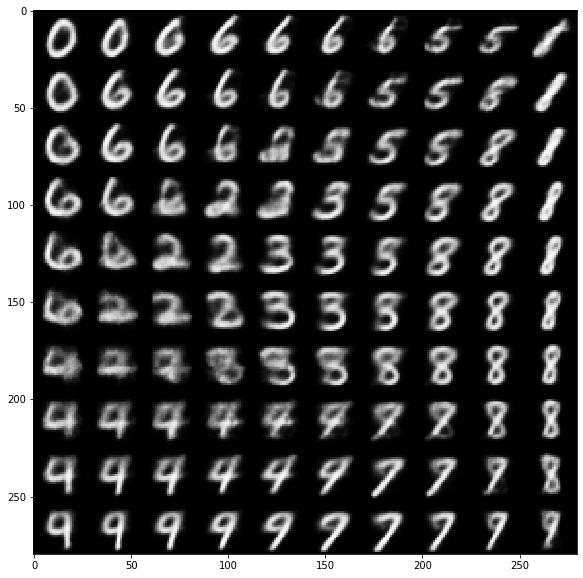

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()